In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, factorial


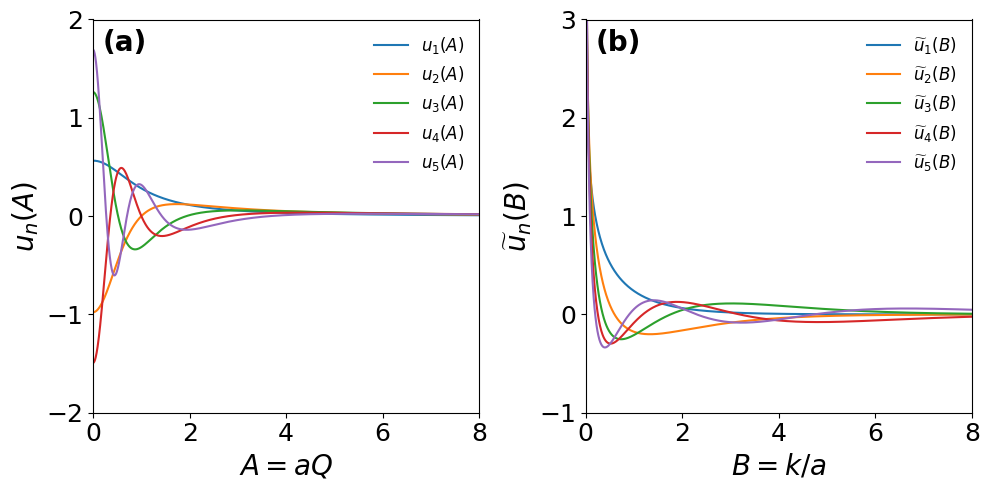

In [17]:
# Parameters
b = 1  # fixed
n_max = 5

# Coefficient vectors c^{(n)}_j for b=1 (from earlier)
coeffs = {
    1: [1],
    2: [1, -2],
    3: [1, -6, 6],
    4: [1, -12, 30, -20],
    5: [1, -20, 90, -140, 70],
}

def u_n_A(n, A):
    x = 1.0 / (1.0 + A**2)
    c = np.array(coeffs[n], dtype=float)
    # u_n = (a/sqrt(pi))*sqrt(2n-1)*sum_j c_j x^{1+j}
    # For plotting in A, set a=1 w.l.o.g. (overall scale only).
    a = 1.0
    pref = a/np.sqrt(np.pi) * np.sqrt(2*n - 1)
    powers = np.array([1 + j for j in range(len(c))])
    return pref * np.sum(c[:, None] * x[None, :]**powers[:, None], axis=0)

def u_tilde_n_B(n, B):
    c = np.array(coeffs[n], dtype=float)
    a = 1.0
    pref = 1.0/(a*np.sqrt(np.pi)) * np.sqrt(2*n - 1)
    terms = []
    for j, cj in enumerate(c):
        terms.append(cj/(2.0**j * factorial(j)) * (B**j) * kv(j, B))
    return pref * np.sum(terms, axis=0)

# Axes grids
A = np.linspace(0, 8, 1200)
B = np.linspace(1e-3, 8, 1200)  # avoid B=0 for K_n

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
panel_labels = ['(a)', '(b)']
for ax, label in zip(axs, panel_labels):
    ax.text(0.025, 0.975, label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left')

# Left: u_n(A)
for n in range(1, n_max+1):
    axs[0].plot(A, u_n_A(n, A), label=fr'$u_{n}(A)$')
axs[0].set_xlabel(r'$A=aQ$', fontsize=20)
axs[0].set_ylabel(r'$u_n(A)$', fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=18)
axs[0].legend(fontsize=12, frameon=False)
axs[0].set_ylim([-2, 2])
axs[0].set_xlim([0, 8])

# Right: \tilde u_n(B)
for n in range(1, n_max+1):
    axs[1].plot(B, u_tilde_n_B(n, B), label=fr'$\widetilde{{u}}_{n}(B)$')
axs[1].set_xlabel(r'$B=k/a$', fontsize=20)
axs[1].set_ylabel(r'$\widetilde{u}_n(B)$', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=18)
axs[1].legend(fontsize=12, frameon=False)
axs[1].set_ylim([-1, 3])
axs[1].set_xlim([0, 8])

plt.tight_layout()
plt.show()